#Intro to Speech Processing: Audio Pipelines

###Outline:
1.   Representing audio
2.   Pre-processing audio files



##Introduction

We'll use a couple files adapted from the musan copyright free audio library (https://www.openslr.org/resources/17/musan.tar.gz), which includes noise, speech, and music.

Provided are ```example1.wav```, ```example2.wav```, ```example3.wav``` and a ```speech-librivox-0091.wav```





##Representing audio


`raw' audio, spectrograms, MFCCs.. there are lots of ways that features can be extracted to represent audio files. We won't look at all of the ways, but rather just a few simple ones that you might come across.

###Raw audio (wav)

PCM Wav files store audio by directly recording the amplitude of soundwaves registered by a microphone. 

Standard format for speech related audio tasks is 16khz PCM with 16 bit-depth.

Lossy formats, such as mp3, may introduce artifacts in the compression, which make them undesireable for audio classification tasks, and could potentially increase WER for ASR if the model has been trained on only lossless audio.


**Using sox and our sample let's inspect a file:**

In [ ]:
from IPython.display import Audio

Audio("/speech-librivox-0091.wav")


In [ ]:
!sox --i speech-librivox-0091.wav


Input File     : '/content/musan/speech/librivox/speech-librivox-0091.wav'
Channels       : 1
Sample Rate    : 16000
Precision      : 16-bit
Duration       : 00:00:56.27 = 900284 samples ~ 4220.08 CDDA sectors
File Size      : 1.80M
Bit Rate       : 256k
Sample Encoding: 16-bit Signed Integer PCM



Number of samples here refers to how many 16-bit numbers are used to represent the full length of audio.

**Now let's try to load it and display it (as a standard spectrogram) with Librosa...**

We'll do so with the following steps.

1. Load the audio
2. Apply a short-time fourier transform to convert from time to the frequency domain.  (each column of the spectrogram represents the output of a discrete fourier transform applied to a window of the input audio)
3. Scale the audio (normalize amplitude based off the largest slice of audio, then convert to a decible scale)

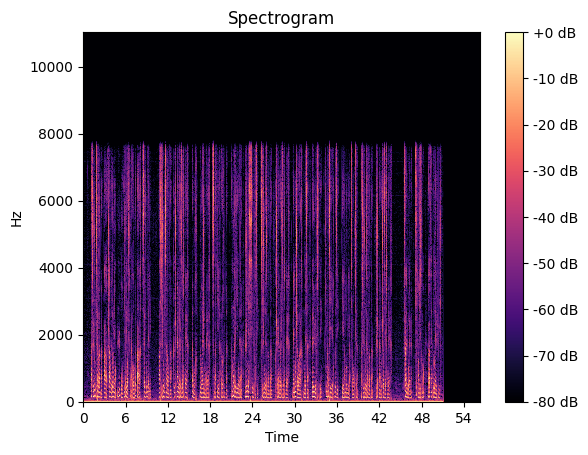

In [ ]:
import librosa
import torchaudio as ta
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio


s, sr = librosa.load("speech-librivox-0091.wav")
D = librosa.stft(s)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

fig, ax = plt.subplots()
img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax, auto_aspect=False)
ax.set(title='Spectrogram')
fig.colorbar(img, ax=ax, format="%+2.f dB")



It looks funny. Why is there so much black space on the spectrogram? The last few seconds of audio are blank, but that doesn't explain why everything above 8khz is blank!.

Let's try to fix it by ensuring the sample rate is correct (Librosa uses default settings for doing music analysis)

(900284,)
(1025, 1759)
(1025, 1759)


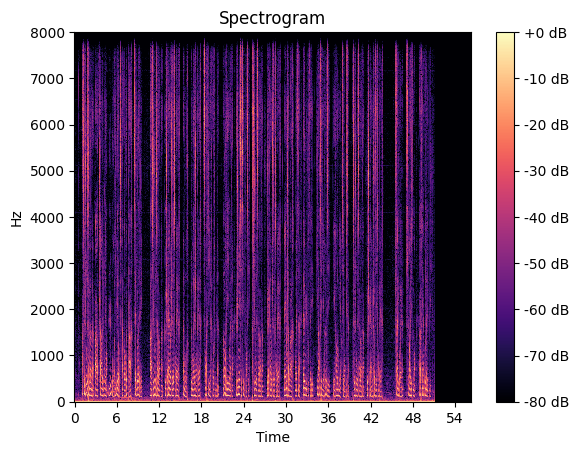

In [ ]:
sr = librosa.get_samplerate("speech-librivox-0091.wav")
assert sr == 16000
s, sr = librosa.load("speech-librivox-0091.wav", sr=sr)


D = librosa.stft(s)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)


fig, ax = plt.subplots()
img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax, sr=sr, auto_aspect=False)
ax.set(title='Spectrogram')
fig.colorbar(img, ax=ax, format="%+2.f dB")


Librosa has default settings of 22khz sample rate, remember this if you plan on using it!  It's vital that files are loaded with the same sample rate that they were recorded (or resampled) with. 

Standard convention is to make sure the sample rate is detected correctly, and then pass this value directly. **Failure to do so with either training or inference of any model will result in nonsense predictions.**

Let's look at resampling really quickly using **sox** directly 
(torchaudio and librosa can both resample, but they actually end up just calling sox or similar tools, so we'll cut out the middle man for now. To compare see: librosa.resample() or torchaudio.resample())

The format for using sox is 


> sox  **input_file.wav** -e [encoding type] -b [bit depths, e.g. 8, 16 etc.] -c [channels 1, 2] -r [sample rate, 8000, 16000 etc.]  **output_file.wav**



For supported encoding formats see the sox manual, however, generally you'll use signed-integer for 16 bit-depth audio.

In [ ]:
!sox speech-librivox-0091.wav -e signed-integer -b 16 -c 1 -r 8000 speech-librivox-0091-downsampled.wav

In [ ]:
!sox --i speech-librivox-0091-downsampled.wav


Input File     : '/content/speech-librivox-0091-downsampled.wav'
Channels       : 1
Sample Rate    : 8000
Precision      : 16-bit
Duration       : 00:00:56.27 = 450142 samples ~ 4220.08 CDDA sectors
File Size      : 900k
Bit Rate       : 128k
Sample Encoding: 16-bit Signed Integer PCM



In [ ]:
Audio("speech-librivox-0091-downsampled.wav")

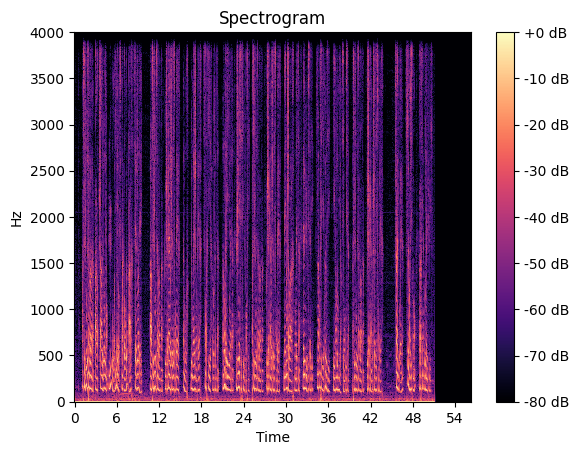

In [ ]:

s, sr = librosa.load("speech-librivox-0091-downsampled.wav", sr=8000)


D = librosa.stft(s)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

fig, ax = plt.subplots()
img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax, sr=sr, auto_aspect=False)
ax.set(title='Spectrogram')
fig.colorbar(img, ax=ax, format="%+2.f dB")


> Note: while we haven't shown changing the bit-depth, bit-depth most matters as a factor for signal to noise ratio in cases where there is audio volume near the maximum dynamic range. In which case, conversion down to a lower bit depth will cause clipping due to maxing out the loudness. 
**Generally keep audio at 16 bit-depth** 



While Librosa is indespensible (especially for displaying spectrograms), Torchaudio supports much of the same functionality, with a bit of increase in speed. We'll use Torchaudio transforms to generate the same spectrogram as before. Since these are transforms, you can generate the transform one time, and then apply this to all of the audio samples at once.



> spec_transform = torchaudio.transforms.Spectrogram(...)

> output_spectrogram_matrix = spec_transform(input_signal)


To perform the same computation on-the-fly you'd use the functional library 
> output_spectrogram_matrix = torchaudio.functional.spectrogram(input_signal...)




torch.Size([1, 900284])
torch.Size([1025, 1759])
(1025, 1759)


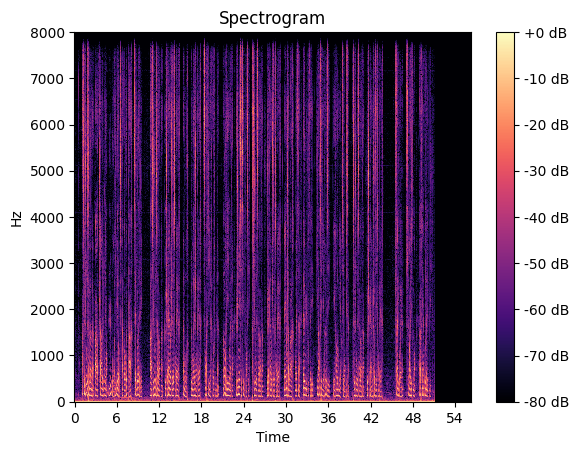

In [ ]:
import torchaudio.transforms as T
import torchaudio.functional as F
import torch

s, sr = ta.load("speech-librivox-0091.wav")

print(s.shape)
spec = T.Spectrogram(power=2, n_fft =2048, hop_length=512)  #using librosa default values to make comparable

D = torch.abs(spec(s)[0])
print(D.shape)
s_db = librosa.power_to_db(D, ref=np.max)

print(s_db.shape)

fig, ax = plt.subplots()
img = librosa.display.specshow(s_db, x_axis='time', y_axis='linear', ax=ax, sr=sr)
ax.set(title='Spectrogram')
fig.colorbar(img, ax=ax, format="%+2.f dB")

In exploring different ways to represent audio, researchers found that by converting audio to a mel-frequency scale improved performance of downstream models. One of the standard representations is thus the **log mel spectrogram**, which we will now demonstrate.

But first lets just take a look at what the mel scale looks like.


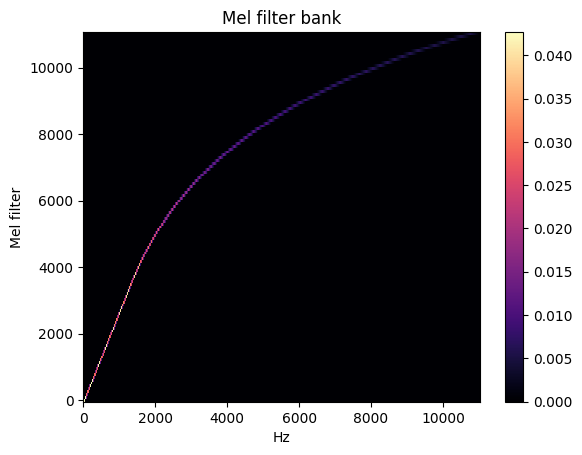

In [ ]:
melfb = librosa.filters.mel(sr=16000, n_fft=2048, fmax=8000)

fig, ax = plt.subplots()
img = librosa.display.specshow(melfb, x_axis='linear', y_axis='linear', ax=ax)
ax.set(ylabel='Mel filter', title='Mel filter bank')
fig.colorbar(img, ax=ax)

It starts out pretty linear, but switches to a logarithmic scaling at higher frequencies. This mimics how humans are good at discerning lower-frequency audio, but bad at differntiating higher frequencies.

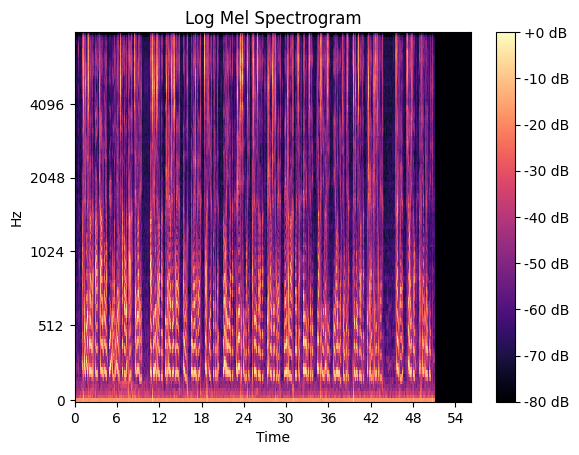

In [ ]:

s, sr = ta.load("speech-librivox-0091.wav")

mel_spec = T.MelSpectrogram(power=2, n_fft =2048, hop_length=512)  #using librosa default values to make comparable

D = torch.abs(mel_spec(s)[0])
s_db = librosa.power_to_db(D, ref=np.max)

fig, ax = plt.subplots()
img = librosa.display.specshow(s_db, x_axis='time', y_axis='mel', ax=ax, sr=sr)
ax.set(title='Log Mel Spectrogram')
fig.colorbar(img, ax=ax, format="%+2.f dB")


The "log" in "log mel spectrogram" comes from applying a log function to the values in the output matrix. 

>Note that often people use decibel (db) scale instead of applying a log() function to the matrix. This is OK since decibel scale is 10log10(x), and makes the scale a little bit more intuitive to interpret.

The final format we'll look are Mel Frequency cepstral coefficients. Which are a set of 12 (+1 Energy usually) features for each frame of audio.

To get MFCCs, you'll take the log mel spectrogram and apply a discrete cosine transformation.

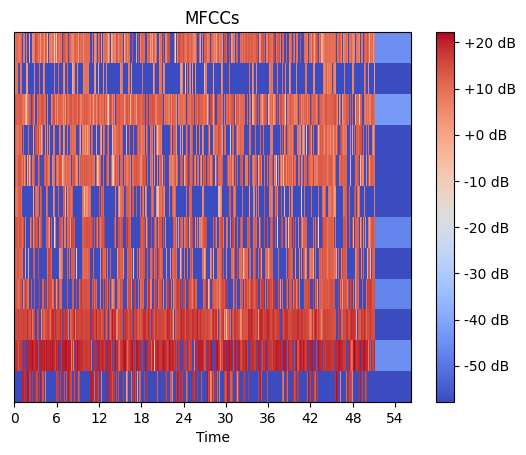

In [ ]:
s, sr = ta.load("speech-librivox-0091.wav")

mel_spec = T.MFCC(n_mfcc=12, sample_rate=sr, melkwargs={
        "n_fft": 2048,
        "n_mels": 128,
        "hop_length": 512,
        "mel_scale": "htk",
    })  #using librosa default values to make comparable

D = mel_spec(s)[0]

fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.power_to_db(D), x_axis='time', ax=ax, sr=sr)
ax.set(title='MFCCs')
fig.colorbar(img, ax=ax, format="%+2.f dB")

#### Section Wrap Up

raw audio: 1D array of (usually) 16 bit numbers representing amplitude
log mel spectrogram: 2D array representing relative energy of frequencies
MFCCs: 2D simplified array also representing energies at different frequencies

Generally for training models from scratch you'd use either a log mel spectrogram representation, or MFCC features.

For self-supervised models such as wav2vec 2.0, these are generally trained on raw audio, however, it is possible to train a model using either log mel spectrograms or MFCCs, what is important is ensuring the input features used during inference match what it is trained on.

### Practice

With the provided files:
```
example1.wav
example2.wav
example3.wav
```
Use either sox or torchaudio/librosa to resample into 'standard' format for audio proccessing.

In [ ]:
# Resample files, for sox uses !sox...
# for non-unix systems, use torchaudio's resample load(), resample(), and save() commands. 


Next create melspectrograms and MFCCs for each of these files

In [ ]:
# log mel spectrogram

In [ ]:
# MFCCs

##Preprocessing


Splitting audio:

VAD

Voice activity detection identifies where there is speaking, silence, noise, music etc.  

We'll use Speechbrain's pretrained models for these steps.




In [18]:
!pip install speechbrain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.0/519.0 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.4/519.4 kB 17.3 MB/s eta 0:00:00


In [20]:
from speechbrain.pretrained import VAD

VAD = VAD.from_hparams(source="speechbrain/vad-crdnn-libriparty", savedir="pretrained_models/vad-crdnn-libriparty")
boundaries = VAD.get_speech_segments("speech-librivox-0091.wav")

# Print the output
VAD.save_boundaries(boundaries)

/usr/local/lib/python3.9/dist-packages/torch/functional.py:641: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:862.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


segment_001  0.00  0.40 NON_SPEECH
segment_002  0.40  51.15 SPEECH


Looks like it got the correct timestamps for the start and end of this file (note it doesn't include blank part at the end 51-56 seconds).



### Practice

Try this out on the three files from earlier (that have been processed into 16khz, 16bit-depth, 1-channel).



In [ ]:
# VAD output for processed example1.wav, example2.wav, example3.wav 

In [21]:
boundaries = VAD.get_speech_segments("example1.wav")

# Print the output
VAD.save_boundaries(boundaries)

segment_001  0.00  10.00 NON_SPEECH
segment_002  10.00  13.66 SPEECH
segment_003  13.66  23.15 NON_SPEECH
segment_004  23.15  24.28 SPEECH
segment_005  24.28  50.00 NON_SPEECH
segment_006  50.00  99.88 SPEECH


In [22]:
boundaries = VAD.get_speech_segments("example2.wav")

# Print the output
VAD.save_boundaries(boundaries)

segment_001  0.00  0.92 NON_SPEECH
segment_002  0.92  69.15 SPEECH
segment_003  69.15  70.00 NON_SPEECH
segment_004  70.00  172.23 SPEECH
segment_005  172.23  176.70 NON_SPEECH
segment_006  176.70  186.11 SPEECH
segment_007  186.11  188.01 NON_SPEECH
segment_008  188.01  219.06 SPEECH
segment_009  219.06  220.00 NON_SPEECH
segment_010  220.00  344.96 SPEECH
segment_011  344.96  350.00 NON_SPEECH
segment_012  350.00  359.67 SPEECH
segment_013  359.67  361.33 NON_SPEECH
segment_014  361.33  469.20 SPEECH
segment_015  469.20  470.00 NON_SPEECH
segment_016  470.00  518.44 SPEECH


In [23]:
boundaries = VAD.get_speech_segments("example3.wav")

# Print the output
VAD.save_boundaries(boundaries)

segment_001  0.00  0.01 NON_SPEECH
segment_002  0.01  27.46 SPEECH
segment_003  27.46  29.21 NON_SPEECH
segment_004  29.21  49.99 SPEECH
segment_005  49.99  50.59 NON_SPEECH
segment_006  50.59  68.56 SPEECH
segment_007  68.56  70.00 NON_SPEECH
segment_008  70.00  77.19 SPEECH
segment_009  77.19  78.51 NON_SPEECH
segment_010  78.51  83.74 SPEECH
segment_011  83.74  85.70 NON_SPEECH
segment_012  85.70  98.43 SPEECH
segment_013  98.43  100.00 NON_SPEECH
segment_014  100.00  116.06 SPEECH
segment_015  116.06  151.69 NON_SPEECH
segment_016  151.69  163.04 SPEECH
segment_017  163.04  164.66 NON_SPEECH
segment_018  164.66  201.99 SPEECH
segment_019  201.99  203.99 NON_SPEECH
segment_020  203.99  208.68 SPEECH
segment_021  208.68  230.00 NON_SPEECH
segment_022  230.00  305.18 SPEECH
segment_023  305.18  305.95 NON_SPEECH
segment_024  305.95  333.60 SPEECH


#### Practice splitting audio

The easiest way to do this is with sox directly


```
sox input.wav output.wav trim START =END
```
For those familiar with BASH, you should be able to automate it going through all the timesteps you've identified with the VAD.


Librosa and Torchaudio also support this by directly manipulating the signal array. However, the array operate on a frame basis, so you'll need to convert (16,000 frames per second). 

Read out the start/stop times of ```example2.wav``` and automatically split it into smaller segments of only speech.


### Speaker Diarization

We're going to look at how Pyaanote does diarization (speechbrain does not have any pretrained models, but can easily be used for diarization or speech separation also).

In [24]:
!pip install -qq https://github.com/pyannote/pyannote-audio/archive/refs/heads/develop.zip

     \ 16.6 MB 5.3 MB/s 0:00:04
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 66.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [25]:

from huggingface_hub import notebook_login
notebook_login()

Token is valid.
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [29]:
from pyannote.audio import Pipeline
pipeline = Pipeline.from_pretrained('pyannote/speaker-diarization', use_auth_token=True)
diarization = pipeline('speech-librivox-0091.wav')

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.0.1.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../root/.cache/torch/pyannote/models--pyannote--segmentation/snapshots/c4c8ceafcbb3a7a280c2d357aee9fbc9b0be7f9b/pytorch_model.bin`


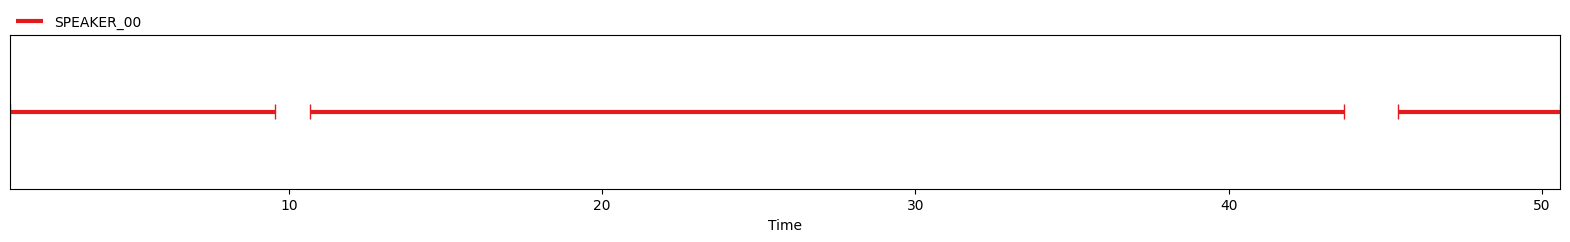

In [30]:
diarization

Looks about right! There is only one speaker in that recording.


### Practice

Try to apply this to the processed ```example3.wav```

(Note need to accept terms / have a huggingface account)